# DataCamp Certification Case Study

### Project Brief

You have been hired by Inn the Neighborhood, an online platform that allows people to rent out their properties for short stays. Currently, the webpage for renters has a conversion rate of 2%. This means that most people leave the platform without signing up. 

The product manager would like to increase this conversion rate. They are interested in developing an application to help people estimate the money they could earn renting out their living space. They hope that this would make people more likely to sign up.

The company has provided you with a dataset that includes details about each property rented, as well as the price charged per night. They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the product manager in a 10 minute presentation. The product manager has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/rentals.csv"`

## 1. Importing and Cleaning

### 1.1 Importing Packages

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

## 1.2 Importing Raw Data

Importing the raw data provided in the _data_ folder:

In [ ]:
# Importing Dataset
rentalsDF = pd.read_csv('data/rentals.csv')
rentalsDF.head(10)

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00
5,8339,37.77525,-122.43637,House,Entire home/apt,1.5,2.0,6,$875.00
6,8739,37.75919,-122.42237,Condominium,Private room,1.0,1.0,1,$139.00
7,9225,37.76259,-122.40543,House,Private room,1.0,1.0,1,$135.00
8,10251,37.75874,-122.41327,House,Entire home/apt,1.0,2.0,30,$225.00
9,10578,37.79143,-122.41544,Apartment,Entire home/apt,1.0,0.0,30,$120.00


## 1.3 Visual Inspection of Data

The _info_ method is used to spot null entries in the columns of the dataframe. The columns 'bathrooms' and 'bedrooms' contain null entries.

In [ ]:
rentalsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


The _nunique_ method is used to spot the amount of unique values in the columns of the dataset.

In [ ]:
# Number of unique values in each column
rentalsDF.nunique()

id                8111
latitude          5059
longitude         5179
property_type       26
room_type            4
bathrooms           17
bedrooms            10
minimum_nights      53
price              526
dtype: int64

In [ ]:
print('The number of duplicate rows is {}.'.format(rentalsDF.duplicated().sum()))

The number of duplicate rows is 0.


### 1.4. Data Cleaning

In this section data is corrected or removed in case there are incomplete entries, inaccurate or irrelevant parts.

#### 1.4.1 Bedrooms Column

This section focuses on the number of bedrooms column. Four null values are found in it.

In [ ]:
# Print entries with empty number of bedrooms
rentalsDF[rentalsDF['bedrooms'].isnull()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
269,431862,37.78321,-122.41969,Apartment,Entire home/apt,1.0,NaN,30,$124.00
6301,32183178,37.78883,-122.48640,House,Entire home/apt,3.5,NaN,30,$650.00
7786,38329898,37.78347,-122.41669,Apartment,Entire home/apt,1.0,NaN,30,$75.00
7840,38550933,37.78979,-122.41994,Apartment,Entire home/apt,1.0,NaN,30,$108.00


To avoid dropping the entries, the amount of bedrooms was estimated based on the room type and using the average bathroom number for entries of similar characteristics.

In [ ]:
# Obtain a list with the unique values of bathrooms for null bedrooms
list_un = rentalsDF[rentalsDF['bedrooms'].isnull()]['bathrooms'].unique()

# Loop over the unique values of bathrooms
for i in list_un:
    # Calculate the average bedrooms for the number of bathrooms and Entire home/apt
    bed_avg = round(rentalsDF['bedrooms'][(rentalsDF['room_type']=='Entire home/apt') & (rentalsDF['bathrooms']==i)].mean())
    
    # Substitute null by the average calculated
    rentalsDF.loc[(rentalsDF['bedrooms'].isnull()) & (rentalsDF['bathrooms']==i),'bedrooms'] = bed_avg

print('After being modified, the number of null values in the bedroom column is {}.'.format(rentalsDF['bedrooms'].isnull().sum()))

After being modified, the number of null values in the bedroom column is 0.


In [ ]:
# Unique values of bedrooms
sorted(list(rentalsDF['bedrooms'].unique()))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 14.0]

For the case of entries where no bedroom is identified, it can be understood that they are studios or smaller flats. In that case, the entries where the number of bedrooms is 0 has been substituted by 1.

In [ ]:
# Change 0 bedrooms to 1
rentalsDF['bedrooms'][rentalsDF['bedrooms'] == 0] = 1

#### 1.4.2 Bathrooms Column

As shared rooms might not have a bathroom directly associated to it, a similar strategy to the one presented in Section 1.4.1 was followed. The average number of bathrooms was estimated for entries with similar characteristics.

In [ ]:
rentalsDF[rentalsDF['bathrooms'].isnull()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
139,144978,37.79336,-122.42506,Apartment,Private room,NaN,1.0,30,$56.00
181,229240,37.79341,-122.40340,Hostel,Shared room,NaN,1.0,1,$45.00
196,259621,37.79470,-122.40374,Hostel,Shared room,NaN,1.0,1,$45.00
197,259622,37.79441,-122.40473,Hostel,Shared room,NaN,1.0,1,$45.00
267,430692,37.75906,-122.40761,Apartment,Private room,NaN,1.0,31,$68.00
352,596042,37.79384,-122.42436,Apartment,Private room,NaN,1.0,30,$63.00
434,785901,37.79313,-122.40443,Hostel,Shared room,NaN,1.0,1,$45.00
435,786492,37.79421,-122.40310,Hostel,Shared room,NaN,1.0,1,$45.00
436,786506,37.79260,-122.40339,Hostel,Shared room,NaN,1.0,1,$45.00
539,1031899,37.74833,-122.42621,Apartment,Entire home/apt,NaN,1.0,30,$127.00


In [ ]:
# Calculate the average bathrooms for the property type and room type
avg_hos_bath= round(rentalsDF[(rentalsDF['property_type']=='Hostel') & (rentalsDF['room_type']=='Shared room')]['bathrooms'].mean())
avg_ap_priv_bath = round(rentalsDF[(rentalsDF['property_type']=='Apartment') & (rentalsDF['room_type']=='Private room') & (rentalsDF['bedrooms']==1)]['bathrooms'].mean())
avg_ap_ent_bath = round(rentalsDF[(rentalsDF['property_type']=='Apartment') & (rentalsDF['room_type']=='Entire home/apt') & (rentalsDF['bedrooms']==1)]['bathrooms'].mean())

# Substitute null by the average calculated
rentalsDF.loc[(rentalsDF['bathrooms'].isnull()) & (rentalsDF['property_type']=='Hostel') & (rentalsDF['room_type']=='Shared room'),'bathrooms'] = avg_hos_bath
rentalsDF.loc[(rentalsDF['bathrooms'].isnull()) & (rentalsDF['property_type']=='Apartment') & (rentalsDF['room_type']=='Private room'),'bathrooms'] = avg_ap_priv_bath
rentalsDF.loc[(rentalsDF['bathrooms'].isnull()) & (rentalsDF['property_type']=='Apartment') & (rentalsDF['room_type']=='Entire home/apt'),'bathrooms'] = avg_ap_ent_bath

print('The number of null values in the bedroom column is {}.'.format(rentalsDF['bathrooms'].isnull().sum()))

The number of null values in the bedroom column is 0.


In [ ]:
rentalsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8111 non-null   float64
 6   bedrooms        8111 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


In [ ]:
rentalsDF['bathrooms'] = rentalsDF['bathrooms'].astype('int64')
rentalsDF['bedrooms'] = rentalsDF['bedrooms'].astype('int64')

print(rentalsDF.dtypes)

id                  int64
latitude          float64
longitude         float64
property_type      object
room_type          object
bathrooms           int64
bedrooms            int64
minimum_nights      int64
price              object
dtype: object


#### 1.4.3 Price Column

In order to convert the 'price' column to float, it is necessary to delete "," and "$" to then be converted to float64. 

In [ ]:
# Converting the Price column from object (str) to float64
rentalsDF['price'] = rentalsDF['price'].str.replace(',','')
rentalsDF['price'] = rentalsDF['price'].str.replace('$','').astype('float64')

print('The type of the Price Column is: {}.'.format(str(rentalsDF['price'].dtypes)))

The type of the Price Column is: float64.


#### 1.4.4 Minimum Nights Column

Using the _describe_ method to detect anomalies and outliers in the data. In the minimum nights column is detected an abnormally large value that could negatively impact the rest of the data. To avoid that, entries whose minimum number of nights were bigger than 365, were dropped.

In [ ]:
# Inspecting the columns
rentalsDF.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8.111000e+03,8111.000000,8111.000000,8111.000000,8111.000000,8.111000e+03,8111.000000
mean,2.024561e+07,37.766054,-122.430107,1.340155,1.451362,1.234526e+04,225.407101
std,1.228565e+07,0.022937,0.026967,0.903651,0.816942,1.110357e+06,412.253039
min,9.580000e+02,37.704630,-122.513060,0.000000,1.000000,1.000000e+00,0.000000
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00,100.000000
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00,150.000000
75%,3.120025e+07,37.785670,-122.410615,1.000000,2.000000,3.000000e+01,240.000000
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


In [ ]:
# Drop entries whose minimum number of nights is above 365 nights
rentalsDF = rentalsDF[rentalsDF['minimum_nights'] < 365]
rentalsDF = rentalsDF.drop('id', axis=1)
rentalsDF.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8099.000000,8099.000000,8099.000000,8099.000000,8099.000000,8099.000000
mean,37.766050,-122.430124,1.340042,1.451167,15.682306,223.447463
std,0.022944,0.026966,0.904117,0.817008,18.941923,394.623139
min,37.704630,-122.513060,0.000000,1.000000,1.000000,0.000000
25%,37.751450,-122.442830,1.000000,1.000000,2.000000,100.000000
50%,37.769160,-122.424670,1.000000,1.000000,4.000000,150.000000
75%,37.785670,-122.410620,1.000000,2.000000,30.000000,240.000000
max,37.828790,-122.368570,14.000000,14.000000,360.000000,10000.000000


## 2. Data Visualization

In this section, categorical data is visualised. The data distribution and correlations are analysed to select the best modelling deployment approach.

In [ ]:
# Calculating the proportion of properties of every type
proportion = 100.*rentalsDF['property_type'].value_counts()/rentalsDF['property_type'].value_counts().sum()
proportion

Apartment             39.930856
House                 28.571429
Condominium           10.989011
Guest suite            7.124336
Boutique hotel         3.296703
Hotel                  1.938511
Townhouse              1.753303
Serviced apartment     1.494012
Hostel                 1.135943
Loft                   1.074207
Bed and breakfast      0.530930
Aparthotel             0.506235
Guesthouse             0.506235
Other                  0.296333
Bungalow               0.209902
Resort                 0.172861
Cottage                0.148166
Villa                  0.123472
Castle                 0.049389
Tiny house             0.037042
Cabin                  0.037042
Earth house            0.024694
Hut                    0.012347
Camper/RV              0.012347
Dome house             0.012347
In-law                 0.012347
Name: property_type, dtype: float64

As there are very small percentages of share for many property types, an alternative category 'Others' was created to encompass those minor categories.

In [ ]:
# Creating a Pie Chart with Property Types
counts = rentalsDF['property_type'].value_counts()
proportion.name = 'proportion'

counts_df = pd.concat([counts,proportion],axis=1).reset_index()

# Selecting values whose proportion is greater than 1.5%
main_coun = counts_df[counts_df['proportion']>1.5]

# Creating an 'Others' category to group types of smaller proportions
others = counts_df[counts_df['proportion']<=1.5]
others_prop = others['proportion'].sum()
others_prop_typ = others['property_type'].sum()
total_cropped = main_coun.append({'index': 'Others',
                    'property_type': others_prop_typ, 'proportion': others_prop} , 
                    ignore_index=True)

total_cropped

,index,property_type,proportion
0,Apartment,3234,39.930856
1,House,2314,28.571429
2,Condominium,890,10.989011
3,Guest suite,577,7.124336
4,Boutique hotel,267,3.296703
5,Hotel,157,1.938511
6,Townhouse,142,1.753303
7,Others,518,6.395851


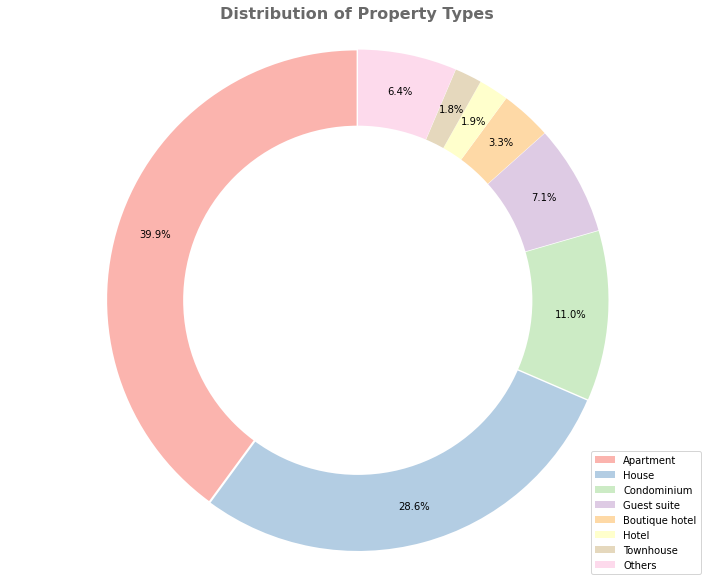

In [ ]:
labels = total_cropped['index'].to_list()
sizes = total_cropped['proportion']
sel_color = '#7ca655'
sel_frame = 'dimgrey'
sel_total = 'dimgrey'

# Colors
colors = sns.color_palette('Pastel1',len(labels))

fig, ax = plt.subplots(figsize=(10, 8))

# Explosion
explode = (0.005,) * len(labels)

plt.pie(sizes, colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(labels)
ax.axis('equal')  
plt.tight_layout()
ax.tick_params(color=sel_frame, labelcolor=sel_frame)
for spine in ax.spines.values():
    spine.set_edgecolor(sel_frame)
fig.tight_layout()
plt.title('Distribution of Property Types', color=sel_frame, fontweight="bold", fontsize=16)
plt.show()

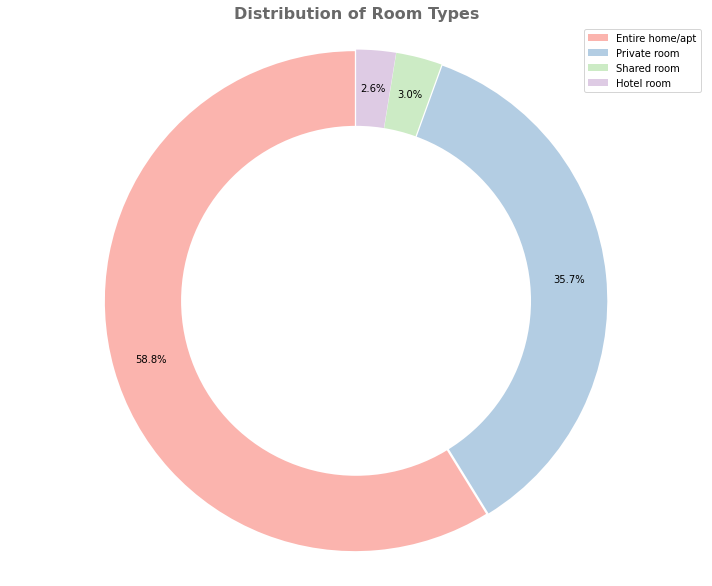

In [ ]:
# Pie Chart
labels = rentalsDF['room_type'].value_counts().index.to_list()
sizes = 100.*rentalsDF['room_type'].value_counts()/rentalsDF['property_type'].value_counts().sum()

# Colors
colors = sns.color_palette('Pastel1',len(labels))

fig, ax = plt.subplots(figsize=(10, 8))

# Explosion
explode = (0.005,) * len(labels)

plt.pie(sizes, colors = colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(labels)
ax.axis('equal')  
plt.tight_layout()
ax.tick_params(color=sel_frame, labelcolor=sel_frame)
for spine in ax.spines.values():
    spine.set_edgecolor(sel_frame)
fig.tight_layout()
plt.title('Distribution of Room Types', color=sel_frame, fontweight="bold", fontsize=16)
plt.show()

### Data Distribution and Correlation

In [ ]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

def pairplot_disp(df,color):
    """Create a Pairplot for the provided dataframe."""
    f = sns.pairplot(df,diag_kind='kde',palette=[color])
    f.map_lower(corrfunc,color='dimgrey')
    plt.show()

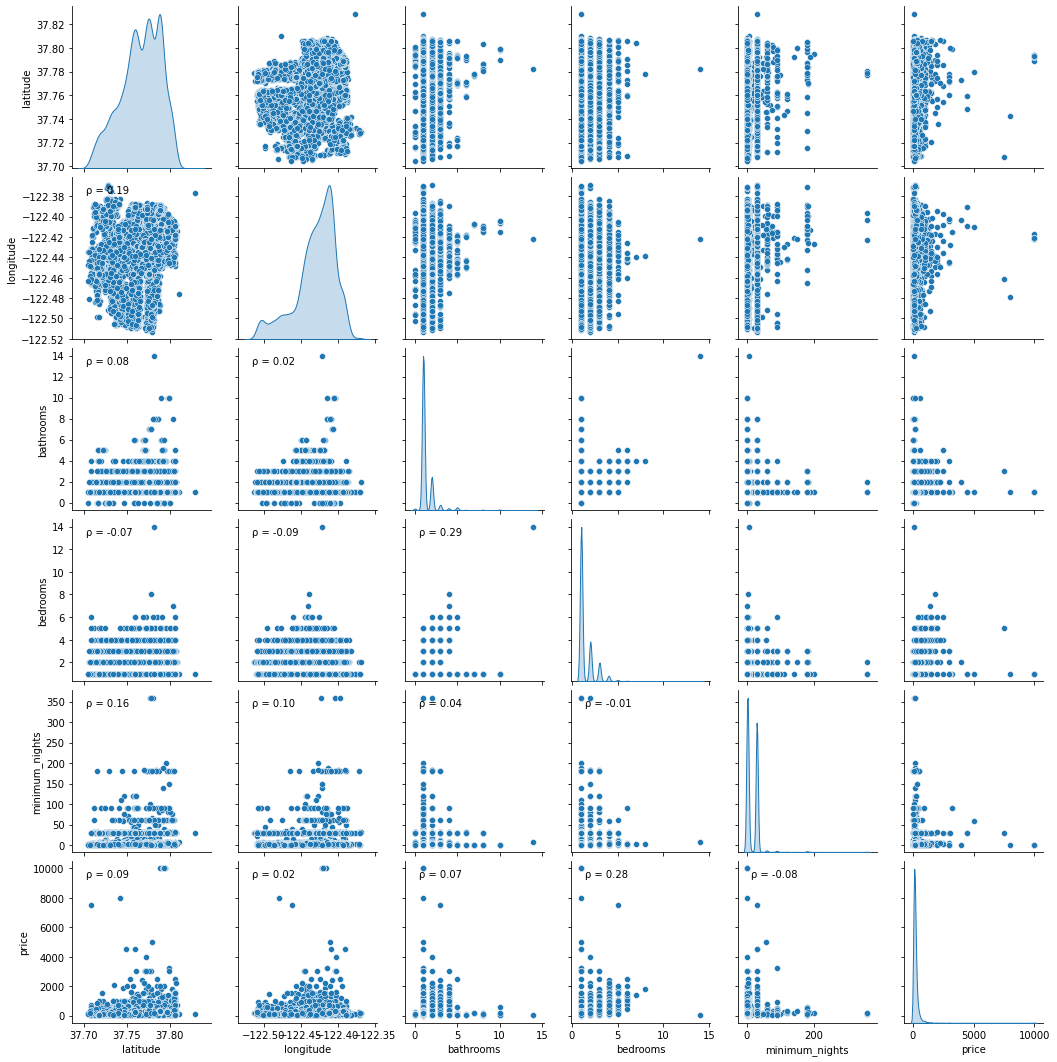

In [ ]:
# Plot pairplot for the whole Dataframe
pairplot_disp(rentalsDF,sel_total)

In [ ]:
def remove_outliers(df,col,qU,qL):
    """Remove a fraction of outliers selecting a quantile of them."""
    qU = df[col].quantile(qU)
    qL = df[col].quantile(qL)
    return df[(df[col]<qU) & (df[col]>qL)]

In [ ]:
# Remove outliers with quantiles
rentalsDF = remove_outliers(rentalsDF,'price',.75,.25)

# Uncomment the line below to remove outliers "Others"
#rentalsDF = rentalsDF[~rentalsDF['property_type'].isin(others['index'].to_list())]

rentalsDF.head(10)

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,37.76931,-122.43386,Apartment,Entire home/apt,1,1,1,170.0
2,37.74511,-122.42102,Apartment,Entire home/apt,1,2,30,235.0
6,37.75919,-122.42237,Condominium,Private room,1,1,1,139.0
7,37.76259,-122.40543,House,Private room,1,1,1,135.0
8,37.75874,-122.41327,House,Entire home/apt,1,2,30,225.0
9,37.79143,-122.41544,Apartment,Entire home/apt,1,1,30,120.0
10,37.77187,-122.43859,Apartment,Entire home/apt,1,3,30,177.0
11,37.77355,-122.42436,Apartment,Entire home/apt,2,3,30,194.0
12,37.78574,-122.40798,Apartment,Entire home/apt,1,1,30,139.0
16,37.76203,-122.45455,Townhouse,Entire home/apt,1,2,30,122.0


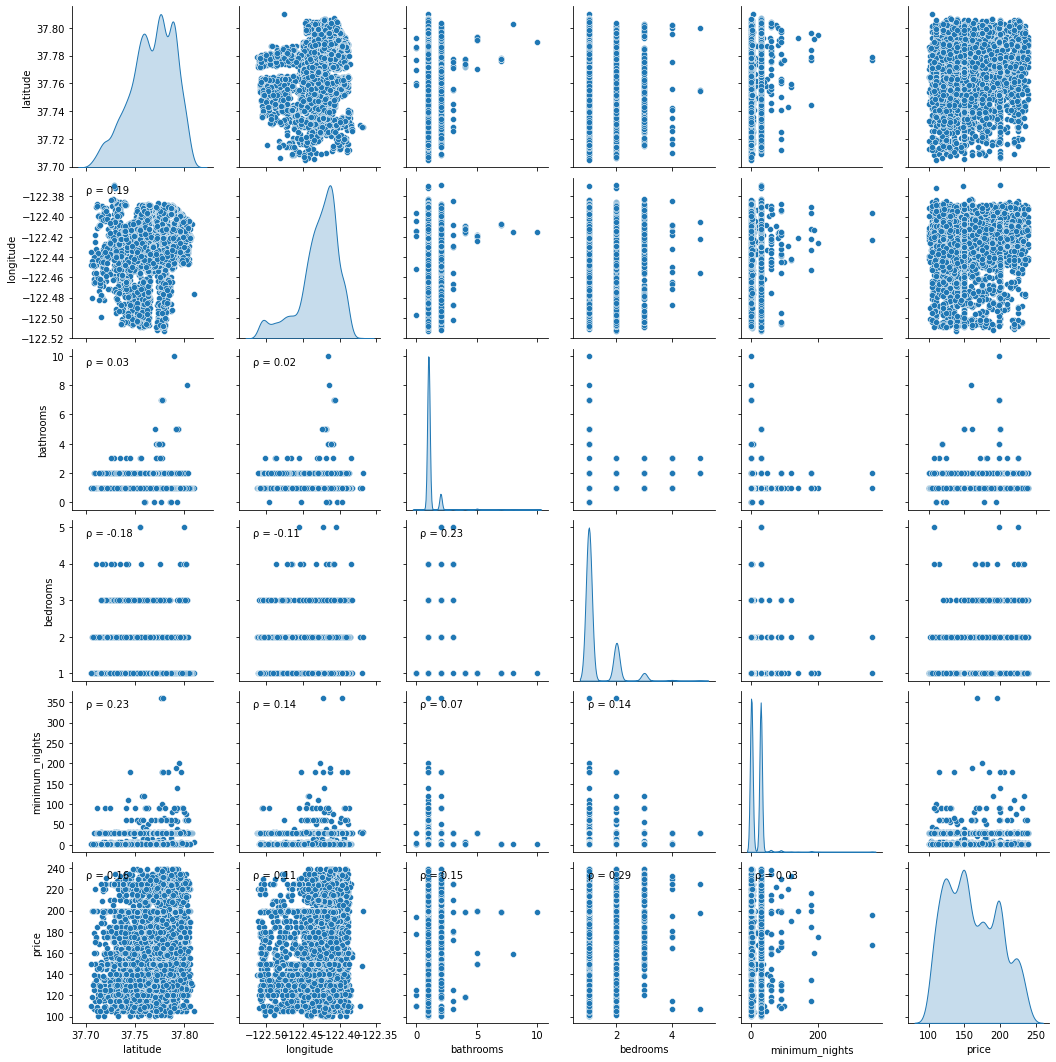

In [ ]:
# Plot pairplot for the whole Dataframe
pairplot_disp(rentalsDF, sel_total)

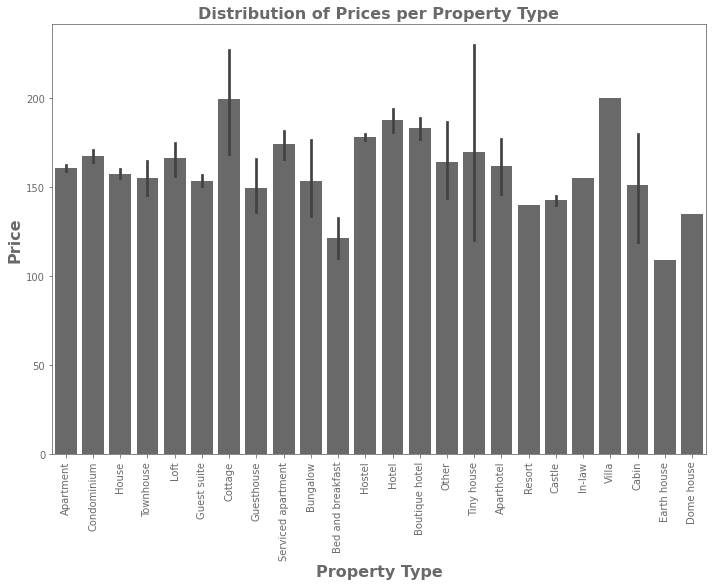

In [ ]:
# Create the Price Distribution per Property Type
fig1 = plt.figure(figsize=(10,8))

ax = plt.gca()

sns.barplot(data = rentalsDF, x = 'property_type', y = 'price', palette= [sel_total])

plt.xticks(rotation=90)
plt.xlabel('Property Type', color=sel_frame, fontweight="bold", fontsize=16)
plt.ylabel('Price', color=sel_frame, fontweight="bold", fontsize=16)
ax.tick_params(color=sel_frame, labelcolor=sel_frame)
for spine in ax.spines.values():
    spine.set_edgecolor(sel_frame)
fig1.tight_layout()
plt.title('Distribution of Prices per Property Type', color=sel_frame, fontweight="bold", fontsize=16)
plt.show()

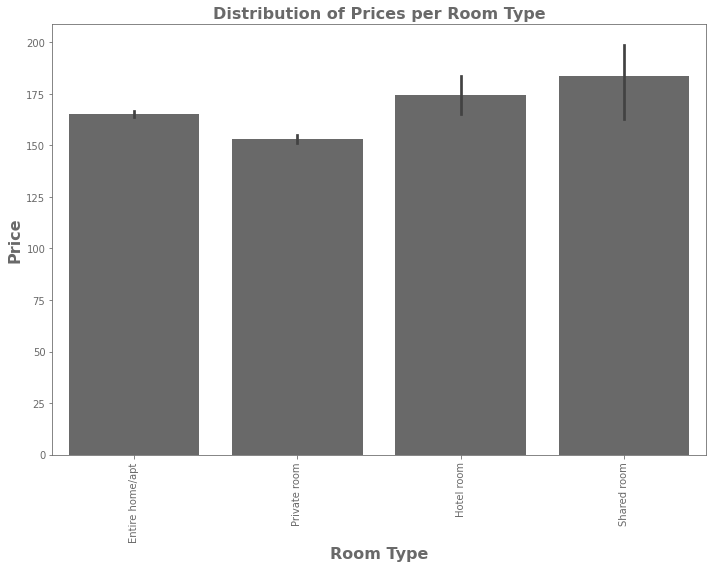

In [ ]:
# Create the Price Distribution per Room Type
fig1 = plt.figure(figsize=(10,8))

ax = plt.gca()

sns.barplot(data = rentalsDF, x = 'room_type', y = 'price', palette= [sel_total])

plt.title('Distribution of Prices per Room Type', color=sel_frame, fontweight="bold", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Room Type', color=sel_frame, fontweight="bold", fontsize=16)
plt.ylabel('Price', color=sel_frame, fontweight="bold", fontsize=16)
ax.tick_params(color=sel_frame, labelcolor=sel_frame)
for spine in ax.spines.values():
    spine.set_edgecolor(sel_frame)
fig1.tight_layout()
plt.show()

### Distribution of Properties on a Map

Plotting the Price Distribution properties on a map to visualise the hottest areas in San Francisco.

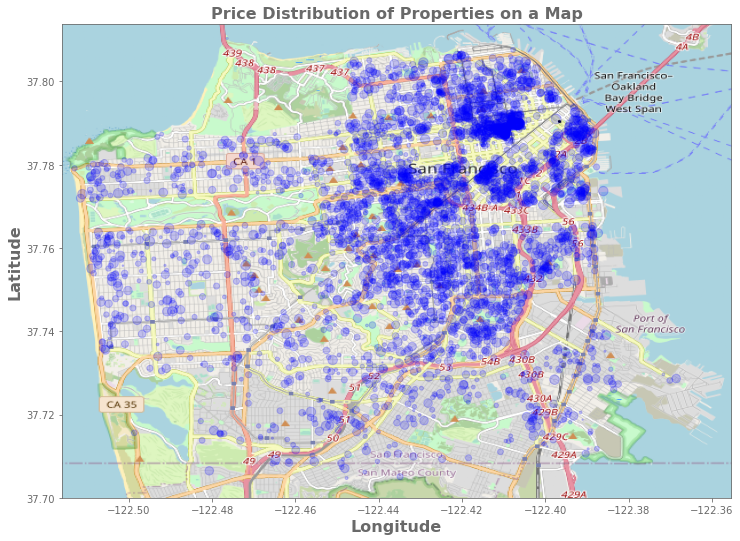

In [ ]:
# Obtained from OpenStreetMap using the minimum and maximum values of the latitude and longitude columns.
mymap = plt.imread('image/map.png')

fig,ax = plt.subplots(figsize=(12,10))

# Create a size vector for the different prices
s = [2+100*(i-rentalsDF['price'].min())/(rentalsDF['price'].max()-rentalsDF['price'].min()) for i in rentalsDF['price']]

ax.scatter(rentalsDF.longitude, rentalsDF.latitude, zorder = 1, alpha = 0.2, c = 'b', s = s)

BBox = [-122.5161,  -122.3553,      
        37.7000, 37.8137]

plt.title('Price Distribution of Properties on a Map', color=sel_frame, fontweight="bold", fontsize=16)
plt.xlabel('Longitude', color=sel_frame, fontweight="bold", fontsize=16)
plt.ylabel('Latitude', color=sel_frame, fontweight="bold", fontsize=16)
ax.tick_params(color=sel_frame, labelcolor=sel_frame)
for spine in ax.spines.values():
    spine.set_edgecolor(sel_frame)
fig1.tight_layout()
        
ax.imshow(mymap, zorder=0, extent = BBox, aspect = 'equal')
plt.show()

## 3. Model Deployment

In order to introduce a regression model for categorical variables, a one-hot encoding is necessary to turn it into binary representation.

In [ ]:
# Apply a One-Hot encoder
rentalOH = pd.get_dummies(rentalsDF,columns=['property_type','room_type'],prefix=['property','room'])

# StandardScaler to improve the efficiency of the models
ss = StandardScaler()
ss.fit(rentalsDF[['latitude','longitude','bedrooms','bathrooms','minimum_nights']])
rentalOH[['latitude','longitude','bedrooms','bathrooms','minimum_nights']] = ss.transform(rentalsDF[['latitude','longitude','bedrooms','bathrooms','minimum_nights']])
rentalOH.head(10)

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price,property_Aparthotel,property_Apartment,property_Bed and breakfast,property_Boutique hotel,...,property_Other,property_Resort,property_Serviced apartment,property_Tiny house,property_Townhouse,property_Villa,room_Entire home/apt,room_Hotel room,room_Private room,room_Shared room
0,0.096345,-0.193974,-0.258309,-0.504269,-0.828130,170.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.012448,0.287470,-0.258309,1.289629,0.681748,235.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,-0.367332,0.236851,-0.258309,-0.504269,-0.828130,139.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,-0.211552,0.872027,-0.258309,-0.504269,-0.828130,135.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,-0.387951,0.578061,-0.258309,1.289629,0.681748,225.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,1.109836,0.496696,-0.258309,-0.504269,0.681748,120.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
10,0.213638,-0.371329,-0.258309,3.083527,0.681748,177.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
11,0.290612,0.162234,1.630668,3.083527,0.681748,194.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
12,0.849132,0.776413,-0.258309,-0.504269,0.681748,139.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
16,-0.237210,-0.969759,-0.258309,1.289629,0.681748,122.0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
def eval_app(model, mae_list_CV, mae_list_MAE):
    """Fit and Evaluate a scikit-learn model"""
    # Train model
    model.fit(X_train,y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate models
    mae = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=10)
    mae_min = min(abs(mae))
    mae_list_CV.append(mae_min)
    
    model_mae = mean_absolute_error(y_test, y_pred)
    mae_list_MAE.append(model_mae)
    return mae_list_CV, mae_list_MAE

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

mae_list_CV = []
mae_list_MAE = []

X = rentalOH.drop('price',axis=1)
y = rentalOH['price']

# Split data in test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Decision Tree Regressor
DT = DecisionTreeRegressor()
eval_app(DT, mae_list_CV, mae_list_MAE)

# Random Forest Regressor
RFR = RandomForestRegressor()
eval_app(RFR, mae_list_CV, mae_list_MAE)

# Gradient boosting Regressor
GBR = GradientBoostingRegressor()
eval_app(GBR, mae_list_CV, mae_list_MAE)

# Support Vector Machine
svm = SVR()
eval_app(svm, mae_list_CV, mae_list_MAE)

# Performance Results
result_dic_CV = {'Decision Tree':round(mae_list_CV[0],2),'Random Forest':round(mae_list_CV[1],2),'Gradient Boosting':round(mae_list_CV[2],2),'SVM':round(mae_list_CV[3],2)}
result_dic_MAE= {'Decision Tree':round(mae_list_MAE[0],2),'Random Forest':round(mae_list_MAE[1],2),'Gradient Boosting':round(mae_list_MAE[2],2),'SVM':round(mae_list_MAE[3],2)}

print(result_dic_CV)
print(result_dic_MAE)

{'Decision Tree': 31.68, 'Random Forest': 23.29, 'Gradient Boosting': 23.31, 'SVM': 24.35}
{'Decision Tree': 30.82, 'Random Forest': 24.22, 'Gradient Boosting': 25.53, 'SVM': 26.03}


Doing some hyper-parameter tuning for the best performing Regression algorithm:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Defining the grid of parameters
params = {'n_estimators': [400,600,800,1000], 'max_features': ['auto', 'sqrt','log2'], 'min_samples_split': [5,7,9,11], 'min_samples_leaf': [1, 2, 4, 5]}

rscv = RandomizedSearchCV(estimator=RFR,param_distributions=params,cv=4,scoring='neg_mean_absolute_error',verbose=1,n_jobs=-1,random_state=1)

rscv.fit(X_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 5],
                                        'min_samples_split': [5, 7, 9, 11],
                                        'n_estimators': [400, 600, 800, 1000]},
                   random_state=1, scoring='neg_mean_absolute_error',
                   verbose=1)

Displaying the best scores and model parameters:

In [ ]:
print('Grid Search Best Score: {:.2f}'.format(abs(rscv.best_score_)))
print('Best Parameters: {}'.format(rscv.best_params_))

# Select the best model obtained
best_model = rscv.best_estimator_
y_pred = best_model.predict(X_test)

print('Best Model MAE: {:.2f}'.format(mean_absolute_error(y_test,y_pred)))

Grid Search Best Score: 25.18
Best Parameters: {'n_estimators': 600, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best Model MAE: 23.91


Creating a Feature Importance graph for the previous model:

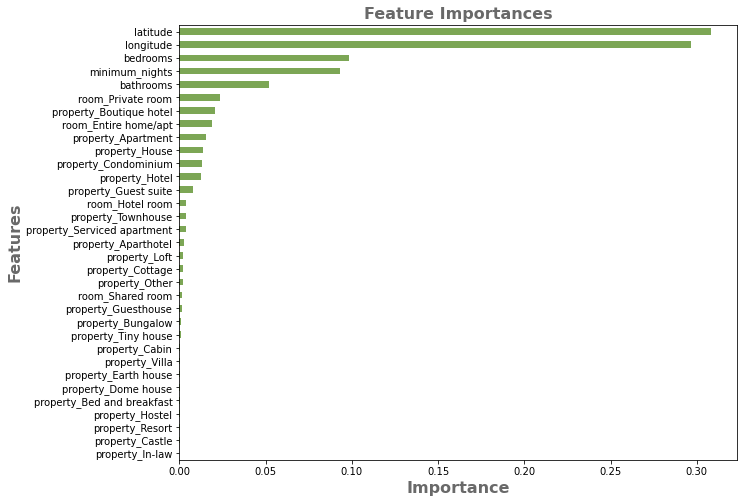

In [ ]:
# Create Series of feature importances
importances_best = pd.Series(best_model.feature_importances_,index=X.columns)

# Sort Importances
sorted_importances = importances_best.sort_values()

# Plot
sorted_importances.plot(kind='barh',figsize=(10,8),color = sel_color)
ax.tick_params(color=sel_frame, labelcolor=sel_frame)
for spine in ax.spines.values():
    spine.set_edgecolor(sel_frame)
fig1.tight_layout()
plt.title('Feature Importances', color=sel_frame, fontweight="bold", fontsize=16)
plt.xlabel('Importance', color=sel_frame, fontweight="bold", fontsize=16)
plt.ylabel('Features', color=sel_frame, fontweight="bold", fontsize=16)
ax.tick_params(color=sel_frame, labelcolor=sel_frame)
plt.show()

## 4. Conclusions and Future Work

### 4.1 Conclusions

- The most relevant parameter to calculate the price of a property is its location.
- There are more properties in the city centre of San Francisco. The closer they are to the centre, the more expensive they tend to be.
- The number of bedrooms have a strong contribution to the price of the rental.
- The correlation between the number of bedrooms and price (0.29) shows that properties with more bedrooms are more expensive.
- Short-stay properties are more frequent than long-stay in the market (above 10 days of minimum rental nights).

### 4.2 Future Work

- To refine the data cleaning process to optimise the properties selected for analysis.
- Explore overpriced places in the analysis.
- Hyper parameter tuning refinement.